In [1]:
import torch
import torch.nn as nn

In [2]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 128,
    "emb_dim" : 708,
    "n_heads" : 12,
    "n_layers" : 11,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}
batch_size = 3

In [3]:
with open("/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/NLP_LLM/antxt.txt", "r", encoding="utf-8") as f:
    text_data = f.read()

print("Total number of charecters in the text: ", len(text_data))
print("\nFirst 100 charecters of raw_text:\n", text_data[:99])
print("\nLast 100 charecters of text_data: \n", text_data[-99:])

Total number of charecters in the text:  1001524

First 100 charecters of raw_text:
 The Project Gutenberg eBook of A Moslem seeker after God
    
This ebook is for the use of anyone a

Last 100 charecters of text_data: 
  produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.






In [4]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()

        self.eps = 1e-05
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):

        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / (torch.sqrt(variance + self.eps))

        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return  0.5 * x * ( 1 + torch.tanh( torch.sqrt(  torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3)  ) ))

class FeedForward(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)
    
class MultiHeadAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):

        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

In [5]:
class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        self.ff = FeedForward(cfg=cfg)
    
    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [6]:
torch.manual_seed(123)

sample_input = torch.rand(2, 4, GPT_CONFIG_124M["emb_dim"])
tb = TransformerBlock(GPT_CONFIG_124M)

print("Shape of input to transformer block: ", sample_input.shape)
output = tb(sample_input)
print("Shape of output of transformer block: ", output.shape)

Shape of input to transformer block:  torch.Size([2, 4, 708])
Shape of output of transformer block:  torch.Size([2, 4, 708])


In [7]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[ TransformerBlock(cfg) for _ in range(cfg["n_layers"]) ]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [9]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

model.eval()

GPTModel(
  (token_emb): Embedding(50257, 708)
  (pos_emb): Embedding(128, 708)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=708, out_features=708, bias=False)
        (W_key): Linear(in_features=708, out_features=708, bias=False)
        (W_value): Linear(in_features=708, out_features=708, bias=False)
        (out_proj): Linear(in_features=708, out_features=708, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=708, out_features=2832, bias=True)
          (1): GELU()
          (2): Linear(in_features=2832, out_features=708, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featur

In [10]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probab = torch.softmax(logits, dim=-1)
        id_next = torch.argmax(probab, dim=-1, keepdim=True)
        idx = torch.cat((idx, id_next), dim=1)
    return idx

In [11]:
# This is a code that generates next max_new_tokens number of new tokens to extend the initial text

def text_to_token_ids(text, tokenizer):
    tokens = tokenizer.encode(text, allowed_special={"<|endoftoken|>"})
    tokens = torch.tensor(tokens).unsqueeze(0)
    return tokens

def token_ids_to_text(idx, tokenizer):
    text = idx.squeeze(0)
    return tokenizer.decode(text.tolist())

start_context = "Every effort moves"
gtt = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer=tokenizer), max_new_tokens=10, context_size=GPT_CONFIG_124M["context_length"])
print(gtt)
print("Generated text: ", token_ids_to_text(gtt, tokenizer=tokenizer))

tensor([[ 6109,  3626,  6100, 22359, 24083,  2841, 24725, 16656, 48350,  1443,
         28090, 45822, 19624]])
Generated text:  Every effort moves tumor gratitudeees saturated Ship maximizingbs Updates Cortana recruitment


In [12]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [13]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print("Probabilities shape: ", probas.shape)

Probabilities shape:  torch.Size([2, 3, 50257])


In [14]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Output:")
print(token_ids)

Output:
tensor([[[22960],
         [13655],
         [ 7763]],

        [[32033],
         [16648],
         [39864]]])


In [15]:
print("Generated text: ")
print(token_ids_to_text(token_ids[0].flatten(), tokenizer=tokenizer))
print("Required text:")
print(token_ids_to_text(targets[0], tokenizer=tokenizer))

Generated text: 
 resemblesgt contained
Required text:
 effort moves you


In [16]:
# Finding loss from logits (output of gpt model) and target

print("Shape of probability output tensor: ", probas.shape)

print("Shape of target: ", targets.shape)

target_probabilities = []
for b in range(probas.shape[0]):
    batc = b
    target_probabilities.append(probas[batc, torch.arange(probas.shape[1]), targets[batc]])
print("Shape of requre: ", target_probabilities)
target_probabilities = torch.cat(target_probabilities, dim=0)
print(target_probabilities)

target_probabilities = torch.log(target_probabilities)
print(target_probabilities)

loss = torch.mean(target_probabilities)
print(loss)
loss = (loss * -1)
print("Loss: ", loss)

Shape of probability output tensor:  torch.Size([2, 3, 50257])
Shape of target:  torch.Size([2, 3])
Shape of requre:  [tensor([1.5757e-05, 1.5602e-05, 5.1567e-06]), tensor([1.0869e-05, 1.4544e-05, 9.5428e-06])]
tensor([1.5757e-05, 1.5602e-05, 5.1567e-06, 1.0869e-05, 1.4544e-05, 9.5428e-06])
tensor([-11.0582, -11.0681, -12.1752, -11.4296, -11.1383, -11.5597])
tensor(-11.4049)
Loss:  tensor(11.4049)


In [17]:
logits_flaten = logits.flatten(0, 1)
target_flaten = targets.flatten(0, 1)
print("shape of logits and target after flatten:")
print(logits_flaten.shape)
print(target_flaten.shape)

shape of logits and target after flatten:
torch.Size([6, 50257])
torch.Size([6])


In [18]:
loss = torch.nn.functional.cross_entropy(logits_flaten, target_flaten)
print(loss)

tensor(11.4049)


In [19]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(89757.9531)


In [20]:
# torch.manual_seed(123)

# model = GPTModel(GPT_CONFIG_124M)

# print("Shape of input: ", batch.shape)

# output = model(batch)

# print("Shape of output: ", output.shape)

In [21]:
# Total_parameters = sum(p.numel() for p in model.parameters())
# print("Total number of parameters in GPT model: ", Total_parameters)

In [22]:
# print("Token embedding layer shape: ", model.token_emb.weight.shape)
# print("Output layer shape: ", model.out_head.weight.shape)

In [23]:
# Total_parameters_gpt2 = Total_parameters - sum(p.numel() for p in model.out_head.parameters())
# print("Total parameters using weight tying: ", Total_parameters_gpt2)

In [24]:
# # To calculate total space requirement

# total_param_bytes = Total_parameters * 4
# total_param_mb = total_param_bytes / (1024*1024)
# print(f"Total memory requirement: {total_param_mb:.2f} MB")

In [25]:
# def generate_text_simple(model, idx, max_new_tokens, context_size):
#     for _ in range(max_new_tokens):
#         idx_cond = idx[:, -context_size:]
        
#         # Get the predictions
#         with torch.no_grad():
#             logits = model(idx_cond)

#         logits = logits[:, -1, :]
#         probab = torch.softmax(logits, dim=-1)
#         id_next = torch.argmax(probab, dim=-1, keepdim=True)
#         idx = torch.cat((idx, id_next), dim=1)
#     return idx

In [26]:
# start_context = "Hello, I am"
# encoded = tokenizer.encode(start_context)
# print("encoded:", encoded)
# encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
# print("encoded_tensor.shape:", encoded_tensor.shape)

In [27]:
# model.eval()

# out = generate_text_simple(
#     model=model,
#     idx=encoded_tensor,
#     max_new_tokens=6,
#     context_size=GPT_CONFIG_124M["context_length"]
# )
# print("Output:", out)
# print("Output length:", len(out[0]))

In [28]:
# print(tokenizer.decode(out.squeeze(0).tolist()))

In [29]:
tokenizer = tiktoken.get_encoding("gpt2")

In [30]:
total_charecters = len(text_data)
tokens = tokenizer.encode(text=text_data)
total_tokens = len(tokens)

print("Total charecters in text data: ", total_charecters)
print("Total tokens after tokenization: ", total_tokens)

Total charecters in text data:  1001524
Total tokens after tokenization:  320834


In [31]:
from torch.utils.data import DataLoader

In [32]:
class GPTDatasetV1:
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.output_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i : i+max_length]
            ouput_chunk = token_ids[i+1 : i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.output_ids.append(torch.tensor(ouput_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]
    
def create_dataloader_v1(txt, max_length, stride, batch_size, shuffle, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length=max_length, stride=stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        drop_last=drop_last,
        shuffle=shuffle,
        num_workers=num_workers
    )
    return dataloader

In [33]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    txt=train_data,
    stride=GPT_CONFIG_124M["context_length"],
    max_length=GPT_CONFIG_124M["context_length"],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    txt=val_data,
    stride=GPT_CONFIG_124M["context_length"],
    max_length=GPT_CONFIG_124M["context_length"],
    batch_size=batch_size,
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [34]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [35]:
print("Training loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValid loader")
for x, y in val_loader:
    print(x.shape, y.shape)

Training loader:
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 128]) torch.Size([3, 128])
torch.Size([3, 12

In [36]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

valid_tokens = 0
for input_batch, target_batch in val_loader:
    valid_tokens += input_batch.numel()

print("Train tokens: ", train_tokens)
print("Validation tokens: ", valid_tokens)
print("Total number of tokens: ", train_tokens + valid_tokens)

Train tokens:  292608
Validation tokens:  27776
Total number of tokens:  320384


In [37]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[ TransformerBlock(cfg) for _ in range(cfg["n_layers"]) ]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [38]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_emb): Embedding(50257, 708)
  (pos_emb): Embedding(128, 708)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=708, out_features=708, bias=False)
        (W_key): Linear(in_features=708, out_features=708, bias=False)
        (W_value): Linear(in_features=708, out_features=708, bias=False)
        (out_proj): Linear(in_features=708, out_features=708, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=708, out_features=2832, bias=True)
          (1): GELU()
          (2): Linear(in_features=2832, out_features=708, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featur

In [39]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0.
    if len(dataloader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    
    for i, (input_batch, target_batch) in enumerate(dataloader):
        loss = calc_loss_batch(input_batch=input_batch, target_batch=target_batch, model=model, device=device)
        total_loss += loss.item()
    
    return total_loss / num_batches

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model.to(device=device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)


print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

Training loss:  11.001613427960654
Validation loss:  10.989713890911782


In [41]:
# print(device)

In [42]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

In [43]:
def generate_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device=device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded, 50, context_size)
    decoded = token_ids_to_text(token_ids, tokenizer)
    print(decoded.replace("\n", " "))
    model.train()

In [44]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, accumulation_steps, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        print("Epoch : ", epoch+1)
        print("\n")
        model.train()
        for i, (input_batch, target_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch=input_batch, target_batch=target_batch, model=model, device=device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Global step: {global_step}"
                      f"Training loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}")
                
        generate_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [45]:
# Pre training loop

import time



In [46]:
prin(sdfs)

NameError: name 'prin' is not defined

In [ ]:
# Later we can load as
checkpoint = torch.load("/home/abhinav/Documents/Work/2 Hobby_projects/Models/LLM_gpt2model/model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

/tmp/ipykernel_61280/48580753.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/abhinav/Documents/Work/2 Hobby_projects/Models/LLM_gpt2model

In [ ]:
start_time = time.time()

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model, 
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    accumulation_steps=1,
    start_context="Every step moves you",
    tokenizer=tokenizer)

end_time = time.time()

print(f"Total time taken for training the LLM: {(end_time - start_time)/60:.2f} minutes")
print("Training completed")

Epoch :  1


Global step: 0Training loss: 1532.242, Validation loss: 149.636
Global step: 5Training loss: 1245.525, Validation loss: 121.686
Global step: 10Training loss: 1183.082, Validation loss: 120.078
Global step: 15Training loss: 1185.404, Validation loss: 122.033
Global step: 20Training loss: 1138.787, Validation loss: 114.750
Global step: 25Training loss: 1117.609, Validation loss: 110.567
Global step: 30Training loss: 1119.752, Validation loss: 113.837
Global step: 35Training loss: 1111.503, Validation loss: 113.798
Global step: 40Training loss: 1299.752, Validation loss: 112.371
Global step: 45Training loss: 1110.052, Validation loss: 108.993
Global step: 50Training loss: 1097.357, Validation loss: 107.217
Global step: 55Training loss: 1076.241, Validation loss: 106.247
Global step: 60Training loss: 1062.995, Validation loss: 105.328
Global step: 65Training loss: 1050.639, Validation loss: 105.851
Global step: 70Training loss: 1047.116, Validation loss: 105.518
Global step: 7

In [ ]:
# Saving the model

torch.save({
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict()
    },
    "/home/abhinav/Documents/Work/2 Hobby_projects/Models/LLM_gpt2model/model_and_optimizer.pth"
)

In [ ]:
# Later we can load as
# checkpoint = torch.load("/home/abhinav/Documents/Work/2 Hobby_projects/Models/LLM_gpt2model/model_and_optimizer.pth")
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["parameter_state_dict"])
# model.train()

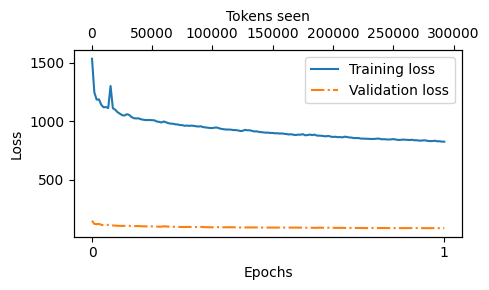

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
# def generate(model, idx, max_new_tokens, context_size, temperature=0.0, topk=None, eos_id=None):
#     for _ in range(max_new_tokens):
#         idx_cond = idx[:, -context_size:]
#         # idx_cond = idx_cond.to(device=device)
#         with torch.no_grad():
#             logits = model(idx_cond)
#         logits = logits[:, -1, :]

#         if topk is not None:
#             top_logits, _ = torch.topk(logits, topk)
#             min_val = top_logits[:, -1]
#             logits = torch.where(condition= logits < min_val, input=torch.tensor(float("-inf")).to(logits.device), other=logits)
        
#         if temperature > 0:
#             logits = logits / temperature
#             probas = torch.softmax(logits, dim=0)
#             id_next = torch.multinomial(probas, num_samples=1)
#         else:
#             id_next = torch.argmax(logits, dim=-1, keepdim=True)
        
#         if id_next == eos_id:
#             break
        
#         idx = torch.cat((idx, id_next), dim=1)
    
#     return idx

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
